Transformer



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, SpatialDropout2D
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import gdown
import os
import zipfile

# Define the URL and data dir
zip_url = 'https://drive.google.com/uc?id=1RIGDq0vDrwr3ugdCFMEyXE-o2JoKj-5D'
data_dir = '/content/dataset'

# Check if the directory exists, if not create it
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download and extract the zip file
zip_file = os.path.join(data_dir, 'image.zip')
gdown.download(zip_url, zip_file, quiet=False)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# List the files in the extracted folder
extracted_files = os.listdir(data_dir)
print("Extracted files:", extracted_files)

Downloading...
From (original): https://drive.google.com/uc?id=1RIGDq0vDrwr3ugdCFMEyXE-o2JoKj-5D
From (redirected): https://drive.google.com/uc?id=1RIGDq0vDrwr3ugdCFMEyXE-o2JoKj-5D&confirm=t&uuid=c3b112e0-adae-4b88-bfaa-3d7ac190bf16
To: /content/dataset/image.zip
100%|██████████| 306M/306M [00:07<00:00, 42.2MB/s]


Extracted files: ['image.zip', 'image']


In [3]:
#relocate the dataset with 5 different name folders
data_image= '/content/dataset/image'

In [4]:
# Initialize the data generators with a validation split
# Create a data generator for training
train_datagen = ImageDataGenerator(
   rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Create a data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Specify the batch size
batch_size = 32

# Create the training dataset
train_ds = train_datagen.flow_from_directory(
    data_image,
    target_size=(224, 224),
    batch_size=batch_size,  # Consider reducing batch size if dataset is small
    class_mode='categorical',
    subset='training')

val_ds =  train_datagen.flow_from_directory(
    data_image,
    target_size=(224, 224),
    batch_size=batch_size,  # Consistent with training batch size
    class_mode='categorical',
    subset='validation')


Found 1957 images belonging to 5 classes.
Found 486 images belonging to 5 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes


9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Set up the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [9]:
# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    epochs=15,
    callbacks=[ early_stopping, reduce_lr]
)

Epoch 1/15
61/61 [==============================] - 157s 2s/step - loss: 0.9498 - accuracy: 0.6592 - val_loss: 0.6308 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 2/15
61/61 [==============================] - 148s 2s/step - loss: 0.5737 - accuracy: 0.8119 - val_loss: 0.5461 - val_accuracy: 0.8146 - lr: 1.0000e-04
Epoch 3/15
61/61 [==============================] - 131s 2s/step - loss: 0.5136 - accuracy: 0.8182 - val_loss: 0.4974 - val_accuracy: 0.8313 - lr: 1.0000e-04
Epoch 4/15
61/61 [==============================] - 147s 2s/step - loss: 0.4347 - accuracy: 0.8473 - val_loss: 0.4689 - val_accuracy: 0.8292 - lr: 1.0000e-04
Epoch 5/15
61/61 [==============================] - 150s 2s/step - loss: 0.4338 - accuracy: 0.8473 - val_loss: 0.4367 - val_accuracy: 0.8562 - lr: 1.0000e-04
Epoch 6/15
61/61 [==============================] - 134s 2s/step - loss: 0.4062 - accuracy: 0.8545 - val_loss: 0.4122 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 7/15
61/61 [==============================] - 

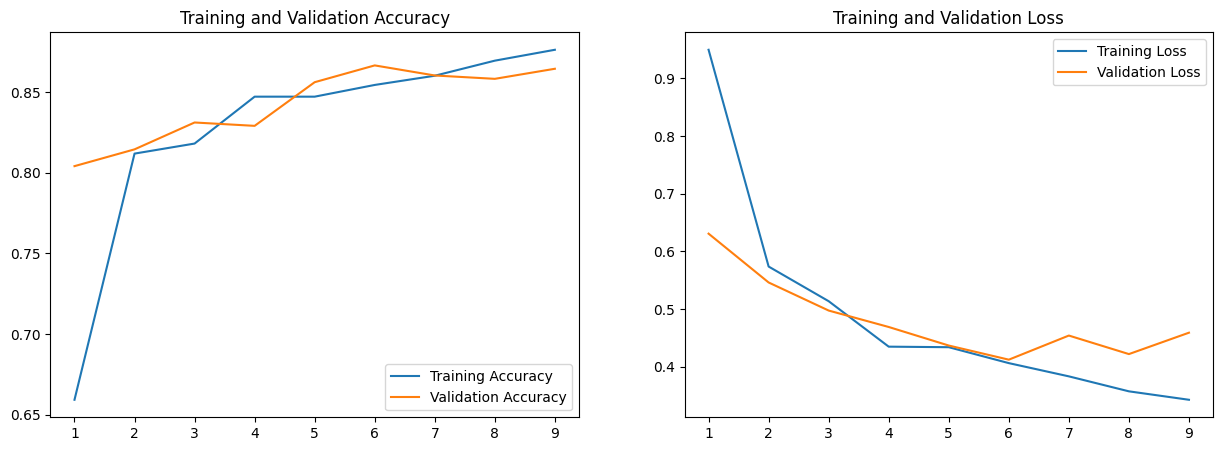

In [14]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('T&V.png')
plt.show()

In [11]:
# Evaluate the model using the validation set
val_preds = model.predict(val_ds)
val_preds_classes = np.argmax(val_preds, axis=1)

true_classes = val_ds.classes
class_labels = list(val_ds.class_indices.keys())


16/16 [==============================] - 29s 2s/step


In [12]:
# Generate a classification report
print(classification_report(true_classes, val_preds_classes, target_names=class_labels))

              precision    recall  f1-score   support

          ad       0.12      0.14      0.13        76
          cv       0.40      0.39      0.40       181
         doc       0.26      0.28      0.27       109
       email       0.15      0.16      0.16        73
       other       0.19      0.09      0.12        47

    accuracy                           0.26       486
   macro avg       0.22      0.21      0.21       486
weighted avg       0.27      0.26      0.26       486



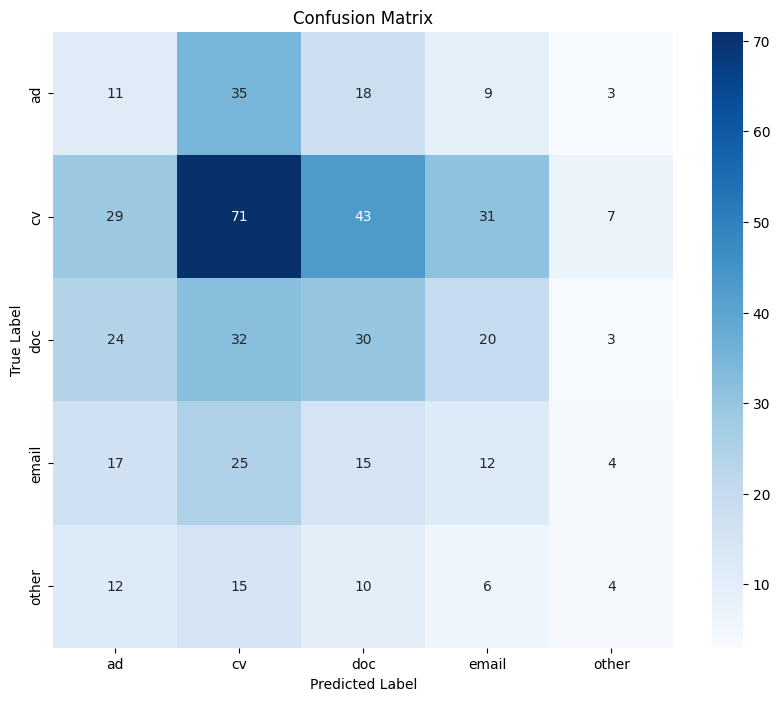

In [13]:
conf_matrix = confusion_matrix(true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('con.png')
plt.show()